In [14]:
import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse

import util
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [19]:
def extract_feats(ffs, direc="train", global_feat_dict=None):
    """
    arguments:
      ffs are a list of feature-functions.
      direc is a directory containing xml files (expected to be train or test).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that
      the columns of the test matrix align correctly.

    returns:
      a sparse design matrix, a dict mapping features to column-numbers,
      a vector of target classes, and a list of system-call-history ids in order
      of their rows in the design matrix.

      Note: the vector of target classes returned will contain the true indices of the
      target classes on the training data, but will contain only -1's on the test
      data
    """
    fds = [] # list of feature dicts
    classes = []
    ids = []
    # x = os.listdir(direc)[1:]
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))
        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
#             print clazz
            assert clazz == "X"
            classes.append(-1)
        rowfd = {}
        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # accumulate features
        [rowfd.update(ff(tree)) for ff in ffs]
        fds.append(rowfd)

    X,feat_dict = make_design_mat(fds,global_feat_dict)
    return X, feat_dict, np.array(classes), ids


def make_design_mat(fds, global_feat_dict=None):
    """
    arguments:
      fds is a list of feature dicts (one for each row).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that
      the columns of the test matrix align correctly.

    returns:
        a sparse NxD design matrix, where N == len(fds) and D is the number of
        the union of features defined in any of the fds
    """
    if global_feat_dict is None:
        all_feats = set()
        [all_feats.update(list(fd.keys())) for fd in fds]
        feat_dict = dict([(feat, i) for i, feat in enumerate(sorted(all_feats))])
    else:
        feat_dict = global_feat_dict

    cols = []
    rows = []
    data = []
    for i in range(len(fds)):
        temp_cols = []
        temp_data = []
        for feat,val in list(fds[i].items()):
            try:
                # update temp_cols iff update temp_data
                temp_cols.append(feat_dict[feat])
                temp_data.append(val)
            except KeyError as ex:
                if global_feat_dict is not None:
                    pass  # new feature in test data; nbd
                else:
                    raise ex

        # all fd's features in the same row
        k = len(temp_cols)
        cols.extend(temp_cols)
        data.extend(temp_data)
        rows.extend([i]*k)

    assert len(cols) == len(rows) and len(rows) == len(data)


    X = sparse.csr_matrix((np.array(data),
                   (np.array(rows), np.array(cols))),
                   shape=(len(fds), len(feat_dict)))
    return X, feat_dict

In [71]:
def count_file_hash(tree):
    c = Counter()
    for el in tree.iter():
        if el.attrib.get("filename_hash") == None:
            continue
        elif el.attrib["filename_hash"] == "hash_error":
            c["file_hash_error"] += 1
    return c
        

def count_src_hash(tree):
    c = Counter()
    for el in tree.iter():
        if el.attrib.get("srcfile_hash") == None:
            continue
        elif el.attrib["srcfile_hash"] == "hash_error":
            c["src_hash_error"] += 1
    return c
        
    
def count_all_reasons(tree):
    c = Counter()
    for el in tree.iter():
        if el.tag == "process":
            c["term" + el.attrib["terminationreason"]] += 1
            c["start" + el.attrib["startreason"]] += 1
            c[el.attrib["executionstatus"]] += 1
    return c

def count_all_attrib(tree):
    c = Counter()
    for el in tree.iter():
        for attrib in el.attrib.keys():
            if attrib in ["shareaccess", "desiredaccess", "filetype", "flags", "protect"]:
                c[el.attrib[attrib]] += 1
            c[attrib] += 1
    return c


# def count_all_flags(tree):
#     c = Counter()
#     for el in tree.iter():
#         if el.attrib.get("flags") == None:
#             continue
#         else:
#             c[el.attrib["flags"]] += 1
#     return c


def count_all_sleep(tree):
    c = Counter()
    for el in tree.iter():
        if el.tag == "sleep":
            c[el.attrib["milliseconds"]] += 1
    return c

def first_last_system_call_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'first_call-x' to 1 if x was the first system call
      made, and 'last_call-y' to 1 if y was the last system call made.
      (in other words, it returns a dictionary indicating what the first and
      last system calls made by an executable were.)
    """
    c = Counter()
    in_all_section = False
    first = True # is this the first system call
    last_call = None # keep track of last call we've seen
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            if first:
                c["first_call-"+el.tag] = 1
                first = False
            last_call = el.tag  # update last call seen

    # finally, mark last call seen
    c["last_call-"+last_call] = 1
    return c

def system_call_count_feats(tree):
    c = Counter()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c[el.tag] += 1
    return c

In [72]:
ffs = [count_file_hash, count_src_hash, count_all_reasons, count_all_attrib, count_all_sleep, first_last_system_call_feats, system_call_count_feats]
X_train, global_feat_dict, t_train, train_ids = extract_feats(ffs, "train")

In [36]:
params = {'max_depth': [5, 10, 25, None],
          'min_samples_split': [2, 5, 10, 15, 20],
          'min_samples_leaf': [1, 5, 10, 15, 20]}
          #'max_features': ['auto', None]}
rfc = RandomForestClassifier(n_estimators=300, random_state=50)
gs = GridSearchCV(rfc, params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs.fit(X_train, t_train)

NameError: name 'X_train' is not defined

In [21]:
gs.best_params_, gs.best_score_

({'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 5},
 0.8976020738820479)

In [22]:
params2 = {'max_depth': [22, 25, 28],
           'max_features': ['auto', None],
           'min_samples_split' : [4,5,6]}
gs2 = GridSearchCV(rfc, params2, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs2.fit(X_train, t_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 11.5min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [22, 25, 28], 'max_features': ['auto', None], 'min_samples_split': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [23]:
gs2.best_params_, gs2.best_score_

({'max_depth': 28, 'max_features': 'auto', 'min_samples_split': 4},
 0.9005184705119896)

In [24]:
params3 = {'min_samples_split' : [3,4,5],
           'max_depth' : [26,28,30]}
gs3 = GridSearchCV(rfc, params3, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs3.fit(X_train, t_train)
gs3.best_params_, gs3.best_score_

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.1min finished


({'max_depth': 26, 'min_samples_split': 4}, 0.9008425145819832)

In [76]:
X_test,_,t_ignore,test_ids = extract_feats(ffs, "test", global_feat_dict=global_feat_dict)

In [18]:
preds = gs3.best_estimator_.predict(X_test)

In [19]:
util.write_predictions(preds, test_ids, "021.csv")

In [84]:
rfc = RandomForestClassifier(n_estimators=300, random_state=50, min_samples_split =4, max_depth = 26)

In [85]:
rfc.fit(X_train, t_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [86]:
preds = rfc.predict(X_test)

In [87]:
util.write_predictions(preds, test_ids, "024.csv")

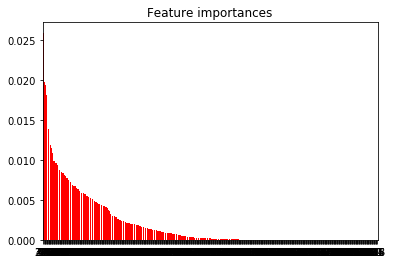

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [97]:
print global_feat_dict

{'FILE_ANY_ACCESS FILE_WRITE_ACCESS FILE_WRITE_DATA FILE_ADD_FILE': 143, 'sleep': 464, 'FILE_ATTRIBUTE_NOT_CONTENT_INDEXED SECURITY_ANONYMOUS': 180, 'load_driver': 404, 'get_host_by_addr': 349, 'create_interface': 287, 'last_call-open_process': 390, '0': 0, 'FILE_ATTRIBUTE_ARCHIVE SECURITY_ANONYMOUS': 164, 'enum_keys': 322, '22000': 46, 'wantedaddress': 511, 'creationflags': 302, 'logon_as_user': 409, 'write_value': 516, 'PAGE_EXECUTE_WRITECOPY': 240, 'PROCESS_ALL_ACCESS PROCESS_CREATE_PROCESS PROCESS_CREATE_THREAD PROCESS_DUP_HANDLE PROCESS_QUERY_INFORMATION PROCESS_SET_INFORMATION PROCESS_TERMINATE PROCESS_VM_OPERATION PROCESS_VM_READ PROCESS_VM_WRITE PROCESS_SET_SESSIONID PROCESS_SET_QUOTA SYNCHRONIZE': 246, 'CouldNotCreateProcess': 129, 'allocationtype': 263, 'starttime': 480, 'PAGE_EXECUTE_READ': 238, 'dump_line': 318, '199': 36, 'INTERNET_FLAG_RELOAD INTERNET_FLAG_NO_CACHE_WRITE INTERNET_FLAG_DONT_CACHE INTERNET_FLAG_NO_COOKIES': 221, 'FILE_ATTRIBUTE_HIDDEN FILE_ATTRIBUTE_SYSTEM 